In [1]:
%run simulator.py

ValueError: Neither a TreeSequence, nor simulation parameters were provided.

In [6]:
import simulator

# Read the data:

file = 'simulation_results(1).txt'

hgt_rates, gene_presence_absence_matrices_unfiltered = simulator.read_simulation_results(file)

# Filter out completely lost genes:

gene_presence_absence_matrices = []
for i in range(0,len(gene_presence_absence_matrices_unfiltered)):
    gene_presence_absence_matrices.append(np.array([row for row in gene_presence_absence_matrices_unfiltered[i] if not (np.all(row == 0))]))
    #gene_presence_absence_matrices.append(np.array([row for row in gene_presence_absence_matrices_unfiltered[i] if not (np.all(row == 0) or np.all(row == 1))]))

# 

gene_presence_absence_matrices[1]



array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.

In [60]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering

def reorder_columns_by_hamming(matrix):
    """
    Ordnet die Spalten der Matrix basierend auf dem Hamming-Abstand.
    """
    # Schritt 1: Berechne die Hamming-Distanz zwischen den Spalten
    hamming_distances = pdist(matrix.T, metric='hamming')  # Transponiere, da wir Spalten vergleichen
    
    # Schritt 2: Hierarchisches Clustering durchführen
    linkage_matrix = linkage(hamming_distances, method='average')  # Average-Linkage-Clustering
    
    # Schritt 3: Bestimme die Reihenfolge der Spalten
    column_order = leaves_list(linkage_matrix)
    
    # Schritt 4: Ordne die Spalten gemäß der neuen Reihenfolge
    reordered_matrix = matrix[:, column_order]
    
    return reordered_matrix

def custom_distance(matrix):
    """
    Computes a custom distance matrix for rows in the matrix.
    Distance = Hamming distance / (Sum of 1s in both rows).
    
    Args:
    - matrix (numpy.ndarray): Input matrix
    
    Returns:
    - numpy.ndarray: Custom distance matrix (condensed form)
    """
    num_rows = matrix.shape[0]
    distance_matrix = []
    
    for i in range(num_rows):
        for j in range(i + 1, num_rows):
            # Calculate Hamming distance
            hamming_dist = np.sum(matrix[i] != matrix[j])
            # Calculate the sum of 1s in both rows
            sum_of_ones = np.sum(matrix[i]) + np.sum(matrix[j])
            # Compute custom distance
            distance = hamming_dist / sum_of_ones if sum_of_ones != 0 else np.inf
            distance_matrix.append(distance)
    
    return np.array(distance_matrix)

def cluster_and_sum_rows(matrix, num_clusters):
    """
    Clusters the rows of a matrix based on a custom distance and sums the rows within each cluster.
    
    Args:
    - matrix (numpy.ndarray): Input matrix
    - num_clusters (int): Number of clusters to create
    
    Returns:
    - summed_clusters (numpy.ndarray): Summed rows for each cluster
    - labels (list): Cluster labels for each row
    """
    # Step 1: Compute custom distance matrix
    custom_distances = custom_distance(matrix)
    
    # Step 2: Perform hierarchical clustering
    clustering_model = AgglomerativeClustering(
        n_clusters=num_clusters, metric='precomputed', linkage='average'
    )
    clustering_model.fit(squareform(custom_distances))
    labels = clustering_model.labels_
    
    # Step 3: Sum rows within each cluster
    summed_clusters = []
    for cluster_id in range(num_clusters):
        # Select rows belonging to the current cluster
        cluster_rows = matrix[labels == cluster_id]
        # Compute the sum of the rows in this cluster
        summed_clusters.append(cluster_rows.sum(axis=0))
    
    return np.array(summed_clusters)

# Specify the number of clusters
num_clusters = min(matrix.shape[0] for matrix in gene_presence_absence_matrices)
print(num_clusters)

ordered_gene_presence_absence_matrices = []
for i in range(0,len(gene_presence_absence_matrices)):
    summed_clusters = cluster_and_sum_rows(gene_presence_absence_matrices[i], num_clusters)
    ordered_gene_presence_absence_matrices.append(reorder_columns_by_hamming(summed_clusters))

simulated_data = [torch.tensor(matrix, dtype=torch.float32) for matrix in ordered_gene_presence_absence_matrices]

if all(isinstance(t, torch.Tensor) for t in simulated_data):
    try:
        # Stack tensors along a new dimension
        simulated_data = torch.stack(simulated_data, dim=0)
    except RuntimeError:
        # If stack fails due to mismatched sizes, concatenate along the first dimension
        simulated_data = torch.cat(simulated_data, dim=0)

hgt_rates_simulations = torch.tensor(hgt_rates)
hgt_rates_simulations = hgt_rates_simulations.view(-1, 1)  # Umformung zu einer Batch-Dimension


5


In [131]:
import torch.nn as nn
from sbi import utils
from sbi.neural_nets import posterior_nn
import torch.nn.functional as F


class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Angepasster Convolutional Layer mit einem anderen Kernel-Size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        # Maxpool-Schicht mit angepasstem Kernel
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        # Fully connected Layer
        self.fc = nn.Linear(in_features=6 * 4 * 19, out_features=2)
        
    def forward(self, x):
        x = x.view(-1, 1, 5, 20)  # Sicherstellen, dass der Input 4D-Tensor ist
        #print(f"Input size: {x.size()}")
        x = self.pool(F.relu(self.conv1(x)))  # Convolution + ReLU + Pooling
        #print(f"Size after conv and pooling: {x.size()}")
        x = x.view(-1, 6 * 4 * 19)  # Flatten nach Pooling-Schicht
        #print(f"Size after flattening: {x.size()}")
        x = F.relu(self.fc(x))  # Fully connected Layer
        #print(f"Size after fully connected: {x.size()}")
        return x




embedding_net = SummaryNet()

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(density_estimator=neural_posterior)

density_estimator = inference.append_simulations(hgt_rates_simulations, simulated_data).train()
posterior = inference.build_posterior(density_estimator)



C:\Users\uhewm\AppData\Local\Temp\ipykernel_27144\3784989356.py:34: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  neural_posterior = utils.posterior_nn(


 Neural network successfully converged after 140 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor([0.4063])


C:\Users\uhewm\AppData\Local\Temp\ipykernel_27144\453602623.py:11: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  pairplot(samples, points=[hgt_rate_test], points_colors=['r'] )


(<Figure size 1000x1000 with 1 Axes>,
 array([[<Axes: xlabel='dim 1'>]], dtype=object))

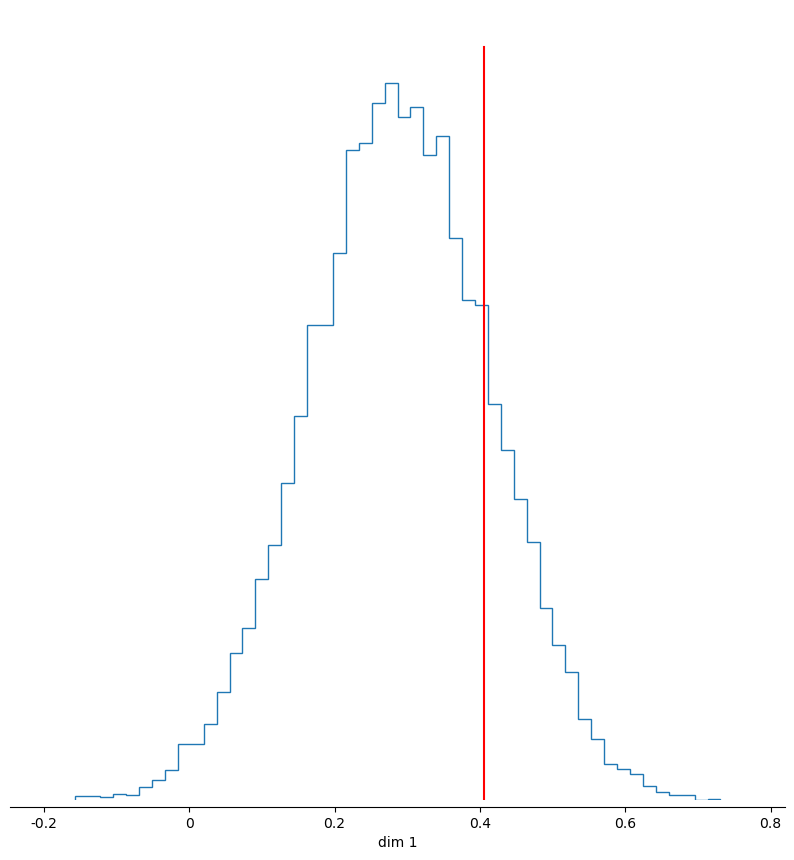

In [141]:
import random
from sbi.analysis import pairplot

z = random.randint(0, 999)
hgt_rate_test = hgt_rates_simulations[z]
x_test = simulated_data[z]

samples = posterior.sample((10000,), x=x_test)

print(hgt_rate_test)
pairplot(samples, points=[hgt_rate_test], points_colors=['r'] )


In [106]:
hgt_rates_simulations


tensor([[9.0787e-02],
        [1.7230e-01],
        [2.6943e-01],
        [2.3514e-01],
        [2.2200e-01],
        [1.6820e-01],
        [2.9324e-01],
        [2.3837e-01],
        [3.0618e-01],
        [1.6135e-01],
        [1.2470e-01],
        [1.6197e-01],
        [2.3339e-01],
        [4.8533e-01],
        [4.6827e-01],
        [3.6124e-01],
        [1.0860e-01],
        [1.4637e-01],
        [4.6019e-01],
        [4.9646e-01],
        [3.8332e-01],
        [3.7194e-01],
        [4.2999e-01],
        [8.3996e-02],
        [3.2411e-01],
        [4.4744e-01],
        [6.0500e-02],
        [1.6664e-01],
        [7.4541e-02],
        [7.1713e-02],
        [2.7786e-02],
        [3.8539e-02],
        [2.6213e-01],
        [4.6881e-02],
        [2.2853e-01],
        [3.5737e-01],
        [2.5976e-01],
        [4.5523e-01],
        [4.3778e-01],
        [3.5027e-01],
        [2.6574e-01],
        [4.6302e-01],
        [4.8656e-01],
        [3.1460e-01],
        [4.1634e-02],
        [4

In [94]:
hgt_rates_simulations = hgt_rates_simulations.view(-1, 1)  # Umformung zu einer Batch-Dimension
